In [34]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

Mean Squared Error (MSE): 86.31
R² Score: -0.26
Top 5 Features:
Frontal Pole Volume Change                0.187472
Subcallosal Cortex Change                 0.154640
Central Opercular Cortex Volume Change    0.127358
Cuneal Cortex Volume Change               0.092594
Frontal Opercular Cortex Volume Change    0.079948
dtype: float64


/var/folders/90/qbmnblws2t16bv6092vjyq1r0000gn/T/ipykernel_30767/2794504602.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_features, y=top_5_features.index, palette='viridis')


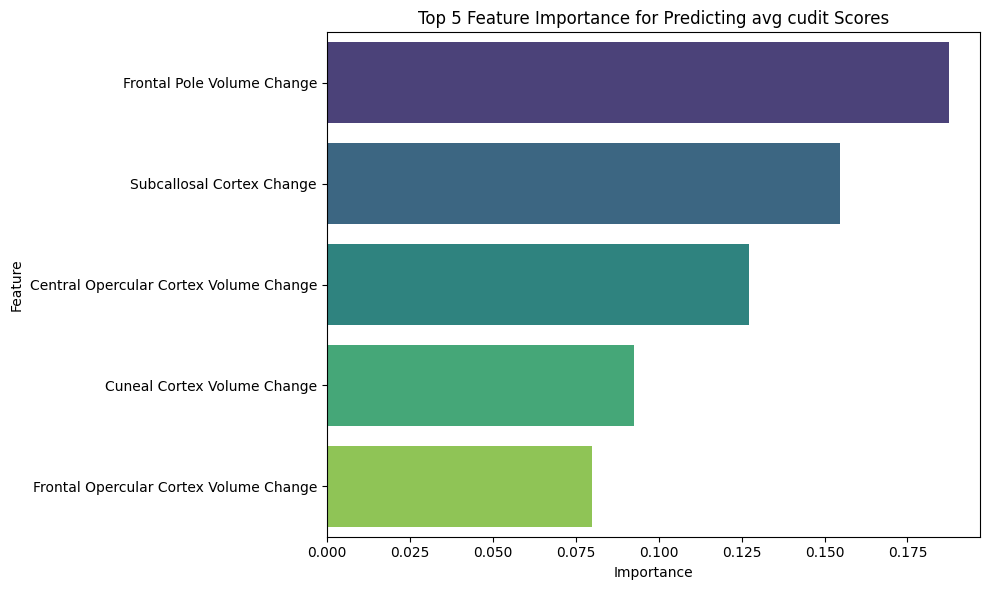

In [35]:
# Load the data
file_path = 'participants_with_changes.xlsx'  # Ensure the file is in the working directory
df = pd.read_excel(file_path)
df['avg cudit'] = (df['cudit total baseline'] + df['cudit total follow-up']) / 2
df = df.drop(columns=['Baseline File Path', 'Followup File Path'])

# Data Preprocessing
# Identify and encode categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = df.copy()

# Encode all categorical columns except the target
for col in categorical_cols:
    if col != 'avg cudit':  # Don't encode the target
        df_encoded[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Remove other CUDIT columns from the features
# Exclude columns related to CUDIT scores from features
columns_to_exclude = [
    'avg cudit', 'cudit total baseline', 'cudit total follow-up',
    'audit total baseline', 'audit total follow-up', 'participant_id', 
    'group', 'age at onset first CB use', 'age at onset frequent CB use'
]
X = df_encoded.drop(columns=columns_to_exclude, errors='ignore')  # Exclude irrelevant columns
y = df_encoded['avg cudit']

# Handle missing values by imputing with mean
X.fillna(X.mean(), inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# Predict and evaluate
y_pred = gbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Feature Importance
feature_importances = pd.Series(gbr.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the top 5 most important features
top_5_features = feature_importances.head(5)
print("Top 5 Features:")
print(top_5_features)

# Visualize Top 5 Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_features, y=top_5_features.index, palette='viridis')
plt.title('Top 5 Feature Importance for Predicting avg cudit Scores')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [36]:
# Load the data
file_path = 'participants_with_changes.xlsx'  # Ensure this file is in the working directory
df = pd.read_excel(file_path)
df['avg cudit'] = (df['cudit total baseline'] + df['cudit total follow-up']) / 2

# Drop irrelevant columns
df = df.drop(columns=['Baseline File Path', 'Followup File Path'])

# Encode categorical columns and drop unnecessary columns
categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = df.copy()
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Exclude columns related to CUDIT scores from features
columns_to_exclude = [
    'avg cudit', 'cudit total baseline', 'cudit total follow-up',
    'audit total baseline', 'audit total follow-up', 'participant_id', 
    'group', 'age at onset first CB use', 'age at onset frequent CB use'
]
X = df_encoded.drop(columns=columns_to_exclude, errors='ignore')
y = df_encoded['avg cudit']

# Impute missing values with the mean
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Prepare a DataFrame to store results
results = pd.DataFrame(columns=['Feature', 'MSE', 'R²', 'P-value'])

# Perform linear regression for each feature with significance testing
for feature in X_imputed.columns:
    # Prepare single feature for regression
    X_feature = X_imputed[[feature]]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.2, random_state=42)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Use statsmodels for significance testing
    X_feature_with_const = sm.add_constant(X_feature)  # Add intercept
    ols_model = sm.OLS(y, X_feature_with_const).fit()
    p_value = ols_model.pvalues[1]  # Get the p-value for the feature (excluding the constant)
    
    # Store the results
    results = pd.concat([
        results, 
        pd.DataFrame({'Feature': [feature], 'MSE': [mse], 'R²': [r2], 'P-value': [p_value]})
    ])

# Sort the results by R² in descending order
results = results.sort_values(by='R²', ascending=False)

# Display the results
print("Linear Regression Results with Significance Testing:")
print(results.head())

# Save results to Excel if needed
results.to_excel('linear_regression_with_significance.xlsx', index=False)

/var/folders/90/qbmnblws2t16bv6092vjyq1r0000gn/T/ipykernel_30767/4268369243.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ols_model.pvalues[1]  # Get the p-value for the feature (excluding the constant)
/var/folders/90/qbmnblws2t16bv6092vjyq1r0000gn/T/ipykernel_30767/4268369243.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([
/var/folders/90/qbmnblws2t16bv6092vjyq1r0000gn/T/ipykernel_30767/4268369243.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer key

Linear Regression Results with Significance Testing:
                                             Feature        MSE        R²  \
0  Inferior Temporal Gyrus, anterior division Vol...  39.696908  0.421890   
0  Heschl's Gyrus (includes H1 and H2) Volume Change  61.868122  0.099008   
0                        Temporal Pole Volume Change  66.122003  0.037058   
0                              Occipital Pole Change  66.986526  0.024468   
0  Inferior Temporal Gyrus, posterior division Vo...  67.646064  0.014863   

    P-value  
0  0.013273  
0  0.167674  
0  0.093469  
0  0.455667  
0  0.460405  


/var/folders/90/qbmnblws2t16bv6092vjyq1r0000gn/T/ipykernel_30767/4268369243.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ols_model.pvalues[1]  # Get the p-value for the feature (excluding the constant)
/var/folders/90/qbmnblws2t16bv6092vjyq1r0000gn/T/ipykernel_30767/4268369243.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ols_model.pvalues[1]  # Get the p-value for the feature (excluding the constant)
/var/folders/90/qbmnblws2t16bv6092vjyq1r0000gn/T/ipykernel_30767/4268369243.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, inte